In [46]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Add this import at the top
import copy

# Reinforcement Learning Trading Bot


## Import Data for TESLA ticker

In [47]:
tesla = yf.Ticker("CSCO")

tesla_data = tesla.history(period='5y')

df = pd.DataFrame(tesla_data)

df.head()


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2019-12-13 00:00:00-05:00,39.285756,39.405555,38.678201,38.763771,21796900,0.0,0.0
2019-12-16 00:00:00-05:00,39.191625,39.867639,39.191625,39.345654,21871300,0.0,0.0
2019-12-17 00:00:00-05:00,39.551019,39.807732,39.302861,39.739273,22510000,0.0,0.0
2019-12-18 00:00:00-05:00,39.807746,40.013115,39.576704,39.910431,21921200,0.0,0.0
2019-12-19 00:00:00-05:00,40.346846,41.065645,40.312617,40.971516,30764700,0.0,0.0


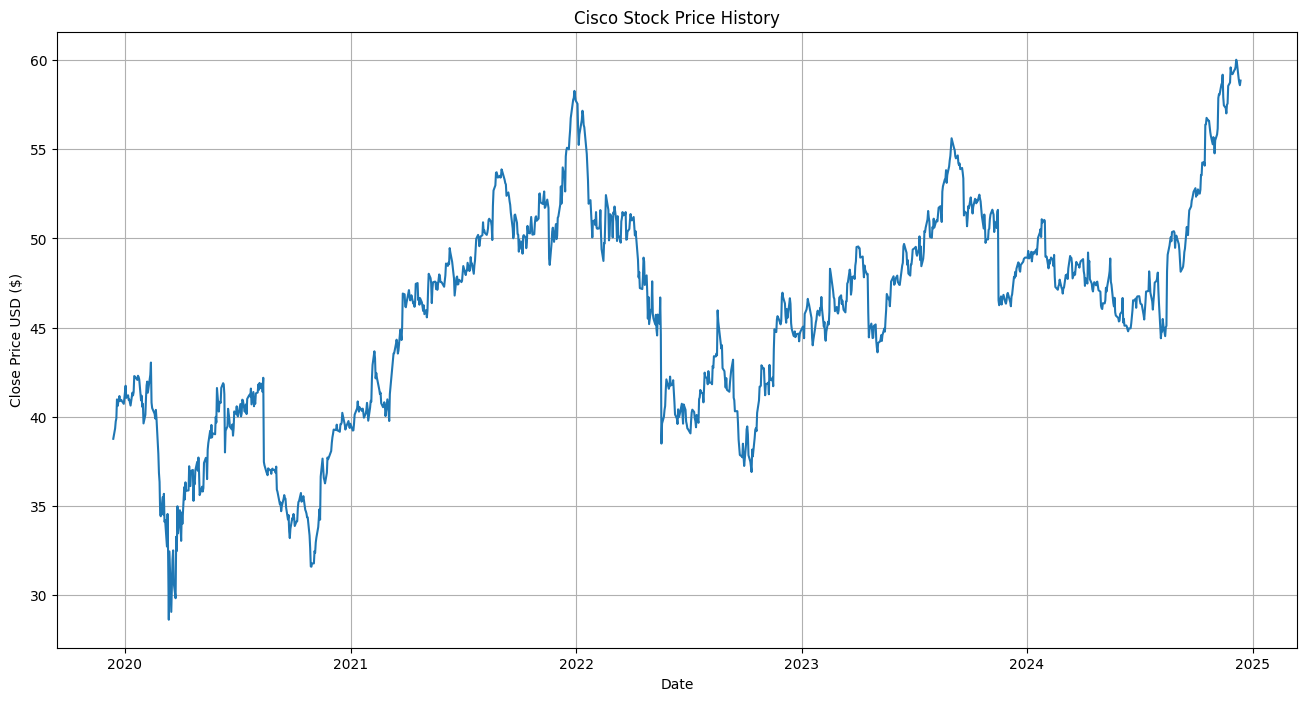

In [48]:
plt.figure(figsize=(16,8))
plt.title('Cisco Stock Price History')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot( df.Close)
plt.grid(True)
plt.show()

## Add some features to the data
- Price Change
- Moving Average
- Volatility
- RSI
- Volume features


In [49]:
def rolling_mean(df, long_window=30, short_window=7):
    # Calculate moving averages
    df['rolling_mean_long'] = df['Close'].rolling(window=long_window, min_periods=1).mean()
    df['rolling_mean_short'] = df['Close'].rolling(window=short_window, min_periods=1).mean()
    
    # Add moving average crossover signal (-1 for sell, 0 for neutral, 1 for buy)
    df['ma_crossover'] = np.where(df['rolling_mean_short'] > df['rolling_mean_long'], 1, 
                                 np.where(df['rolling_mean_short'] < df['rolling_mean_long'], -1, 0))
    
    # Calculate distance from moving averages (normalized)
    df['price_to_ma_long'] = (df['Close'] - df['rolling_mean_long']) / df['rolling_mean_long']
    df['price_to_ma_short'] = (df['Close'] - df['rolling_mean_short']) / df['rolling_mean_short']
    return df

def momentum_indicators(df):
    # Calculate ROC (Rate of Change)
    df['roc_5'] = df['Close'].pct_change(periods=5)
    df['roc_20'] = df['Close'].pct_change(periods=20)
    
    # Calculate RSI
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['rsi'] = 100 - (100 / (1 + rs))
    df['rsi'].fillna(50, inplace=True)  # Neutral RSI for starting values
    
    # RSI signals
    df['rsi_signal'] = np.where(df['rsi'] > 70, -1,  # Overbought
                               np.where(df['rsi'] < 30, 1, 0))  # Oversold
    return df

def volatility(df, window=20):
    # Calculate returns and volatility
    returns = df['Close'].pct_change()
    returns.fillna(0, inplace=True)
    
    df['volatility'] = returns.rolling(window=window, min_periods=1).std()
    df['volatility'].fillna(method='bfill', inplace=True)
    
    # Add Bollinger Bands
    df['bb_middle'] = df['Close'].rolling(window=window).mean()
    bb_std = df['Close'].rolling(window=window).std()
    df['bb_upper'] = df['bb_middle'] + (bb_std * 2)
    df['bb_lower'] = df['bb_middle'] - (bb_std * 2)
    
    # Bollinger Band signals
    df['bb_signal'] = np.where(df['Close'] > df['bb_upper'], -1,  # Sell signal
                              np.where(df['Close'] < df['bb_lower'], 1, 0))  # Buy signal
    
    # Volatility regime
    df['volatility_regime'] = np.where(df['volatility'] > df['volatility'].rolling(window=100).mean(),
                                      1, 0)  # 1 for high volatility, 0 for low
    return df

def volume_indicators(df):
    # Volume moving average
    df['volume_ma'] = df['Volume'].rolling(window=20).mean()
    
    # Volume trend
    df['volume_trend'] = np.where(df['Volume'] > df['volume_ma'], 1, -1)
    
    # Price-volume trend
    df['price_volume_trend'] = df['volume_trend'] * np.sign(df['Close'].pct_change())
    return df

def process_data(df):
    df = rolling_mean(df)
    df = momentum_indicators(df)
    df = volatility(df)
    df = volume_indicators(df)
    
    # Fill any remaining NaN values
    df.fillna(method='bfill', inplace=True)
    df.fillna(method='ffill', inplace=True)
    
    return df

df = process_data(df)

df.describe()

C:\Users\f\AppData\Local\Temp\ipykernel_10696\3237131805.py:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['rsi'].fillna(50, inplace=True)  # Neutral RSI for starting values
C:\Users\f\AppData\Local\Temp\ipykernel_10696\3237131805.py:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a

,Open,High,Low,Close,Volume,Dividends,Stock Splits,rolling_mean_long,rolling_mean_short,ma_crossover,...,rsi_signal,volatility,bb_middle,bb_upper,bb_lower,bb_signal,volatility_regime,volume_ma,volume_trend,price_volume_trend
count,1258.000000,1258.000000,1258.000000,1258.000000,1.258000e+03,1258.000000,1258.0,1258.000000,1258.000000,1258.000000,...,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1.258000e+03,1258.000000,1258.000000
mean,45.702102,46.120287,45.299688,45.725499,2.067493e+07,0.006002,0.0,45.509614,45.678385,0.212242,...,-0.045310,0.014937,45.588886,47.790290,43.387482,-0.018283,0.382353,2.067502e+07,-0.268680,-0.030207
std,5.896975,5.872419,5.933692,5.906810,9.783797e+06,0.047274,0.0,5.575007,5.834812,0.974753,...,0.512701,0.008734,5.679316,5.666606,5.902749,0.319829,0.486155,4.786091e+06,0.963612,0.995955
min,28.644362,30.876955,27.928901,28.618507,5.720500e+06,0.000000,0.0,33.336870,30.844936,-1.000000,...,-1.000000,0.005707,32.456576,35.825664,28.054428,-1.000000,0.000000,1.307458e+07,-1.000000,-1.000000
25%,40.983371,41.318860,40.577888,40.972223,1.517578e+07,0.000000,0.0,40.716110,41.012555,-1.000000,...,0.000000,0.010317,40.867926,43.164216,39.098662,0.000000,0.000000,1.792356e+07,-1.000000,-1.000000
50%,46.576692,46.928079,46.231415,46.599697,1.821120e+07,0.000000,0.0,46.521113,46.567162,1.000000,...,0.000000,0.012383,46.589241,48.444096,44.479419,0.000000,0.000000,1.976366e+07,-1.000000,-1.000000
75%,50.038246,50.431594,49.576455,50.008075,2.260385e+07,0.000000,0.0,49.580555,50.054608,1.000000,...,0.000000,0.016892,49.741481,51.895538,47.976264,0.000000,1.000000,2.214614e+07,1.000000,1.000000
max,60.000000,60.230000,59.770000,60.020000,1.069283e+08,0.400000,0.0,58.216000,59.562857,1.000000,...,1.000000,0.067820,58.707000,60.572861,56.841139,1.000000,1.000000,5.002888e+07,1.000000,1.000000


# Basic RL QLearning setup

In [50]:
import numpy as np
import pandas as pd
import gym
from gym import spaces
import torch
import torch.nn as nn
import torch.optim as optim
import random

In [51]:
class StockTradingEnv(gym.Env):
    def __init__(self, df, initial_balance=100000, RECENT_CHANGE_LENGTH=5):
        super(StockTradingEnv, self).__init__()
        
        self.df = df
        initial_price = df.iloc[0]['Close']

        self.initial_shares_held = int(initial_balance / (2*initial_price))
        self.initial_balance = initial_balance - (self.initial_shares_held * initial_price)
        self.initial_position = 1
        
        
        # Create a more balanced action space:
        # Actions structured as: [position_change, position_size]
        # position_change: 0 (sell), 1 (hold), 2 (buy)  # Changed from -1,0,1 to 0,1,2
        # position_size: 0.0 to 1.0 in steps of 0.25
        self.action_space = spaces.MultiDiscrete([3, 4])  # [3 actions, 4 size levels]
        
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(11,), dtype=np.float32)
        
        self.previous_portfolio_values = []
        self.RECENT_CHANGE_LENGTH = RECENT_CHANGE_LENGTH
        self.reset()

    def _calculate_rsi(self, period=14):
        """
        Calculate the Relative Strength Index (RSI) for the current step
        Args:
            period (int): The period over which to calculate RSI (default: 14)
        Returns:
            float: The RSI value
        """
        if self.current_step < period:
            return 50.0  # Return neutral RSI for initial period
            
        # Get the price changes for the period
        prices = self.df['Close'].iloc[self.current_step - period:self.current_step + 1]
        deltas = prices.diff()
        
        # Separate gains and losses
        gains = deltas.where(deltas > 0, 0.0)
        losses = -deltas.where(deltas < 0, 0.0)
        
        # Calculate average gains and losses
        avg_gain = gains.mean()
        avg_loss = losses.mean()
        
        if avg_loss == 0:
            return 100.0
        
        # Calculate RS and RSI
        rs = avg_gain / avg_loss
        rsi = 100 - (100 / (1 + rs))
        
        return rsi
        

    
    def reset(self):
        self.current_step = 0
        self.position = 0  # No position
        self.balance = self.initial_balance  # Initial balance
        self.done = False
        self.shares_held = self.initial_shares_held
        self.previous_portfolio_values = []
        self.initial_position = 1
        return self._get_observation()
    
    def _get_observation(self):
        obs = np.array([
            self.shares_held / self.initial_position,  # Position size
            self.balance / self.initial_balance,  # Cash ratio
            self.df.iloc[self.current_step]['ma_crossover'],  # MA signal
            self.df.iloc[self.current_step]['price_to_ma_short'],  # Short-term trend
            self.df.iloc[self.current_step]['rsi_signal'],  # RSI signal
            self.df.iloc[self.current_step]['bb_signal'],  # Bollinger Band signal
            self.df.iloc[self.current_step]['volatility_regime'],  # Volatility regime
            self.df.iloc[self.current_step]['volume_trend'],  # Volume trend
            self.df.iloc[self.current_step]['price_volume_trend'],  # Price-volume relationship
            self.df.iloc[self.current_step]['roc_5'],  # Short-term momentum
            self._calculate_rsi() / 100.0,  # Normalize RSI to 0-1 range
        ])
        return obs
    
    
    def step(self, action):
        # Store initial values
        initial_portfolio_value = self.balance + (self.shares_held * self.df.iloc[self.current_step]['Close'])
        current_price = self.df.iloc[self.current_step]['Close']
        
        # Calculate max_shares at the beginning
        max_shares = int(self.balance / current_price) if current_price > 0 else 0
        
        position_change, size_level = action
        position_size = size_level * 0.10
        
        # Get market indicators
        market_trend = 0
        if self.current_step > 20:
            ma20 = self.df['Close'].iloc[self.current_step-20:self.current_step].mean()
            market_trend = (current_price - ma20) / ma20
        
        # Add trading frequency penalty
        trading_penalty = 0
        if not hasattr(self, 'last_trade_step'):
            self.last_trade_step = 0
        
        # Execute trade
        transaction_cost = 0.001  # Increase transaction cost to discourage frequent trading
        old_shares_held = self.shares_held
        made_trade = False

        incorrect_action_penalty = 0
        
        if position_change == 2:  # Buy
            shares_to_buy = int(max_shares * position_size)
            cost = shares_to_buy * current_price * (1 + transaction_cost)
            if cost <= self.balance and shares_to_buy > 0:
                self.balance -= cost
                self.shares_held += shares_to_buy
                made_trade = True
            else: 
                incorrect_action_penalty = -1
                
        elif position_change == 0:  # Sell
            shares_to_sell = int(self.shares_held * position_size)
            if shares_to_sell > 0:
                self.balance += shares_to_sell * current_price * (1 - transaction_cost)
                self.shares_held -= shares_to_sell
                made_trade = True
            else:
                incorrect_action_penalty = -1

        # Apply trading frequency penalty
        if made_trade:
            steps_since_last_trade = self.current_step - self.last_trade_step
            if steps_since_last_trade < 5:  # Penalize trades that happen too frequently
                trading_penalty = -0.002 * (5 - steps_since_last_trade)
            self.last_trade_step = self.current_step
        
        shares_to_sell = int(self.shares_held * position_size)
        shares_to_buy = int(max_shares * position_size)
        # Move to next timestep
        self.current_step += 1
        
        

        # Calculate reward components
        final_portfolio_value = self.balance + (self.shares_held * current_price)

        if len(self.previous_portfolio_values) < self.RECENT_CHANGE_LENGTH:
            self.previous_portfolio_values.append(final_portfolio_value)
            portfolio_return = (final_portfolio_value - initial_portfolio_value) / initial_portfolio_value 
        else:
            self.previous_portfolio_values.pop(0)
            self.previous_portfolio_values.append(final_portfolio_value)
            portfolio_return = (final_portfolio_value - self.previous_portfolio_values[0]) / self.previous_portfolio_values[0]

        # 1. Portfolio return component with holding bonus
        
        
        # 2. Add holding bonus - reward for holding positions during favorable trends
        holding_bonus = 0
        if self.shares_held > 0 and market_trend > 0.01:
            holding_bonus = 0.001  # Small bonus for holding during uptrend
        
        # 3. Profit taking reward (only for significant gains)
        profit_taking_reward = 0
        if position_change == 0 and portfolio_return > 0.02:  # Only reward significant profit taking
            profit_taking_reward = portfolio_return * 0.5
        
        # 4. Position size penalty to discourage very small trades
        position_size_penalty = 0
        if made_trade and (shares_to_buy < max_shares * 0.1 or shares_to_sell < self.shares_held * 0.1):
            position_size_penalty = -0.001  # Penalize very small trades
        
        # Combine all reward components
        reward = (
            portfolio_return * 1.0 +          # Base portfolio return
            holding_bonus * 0.3 +             # Holding bonus
            profit_taking_reward * 0.4 +      # Significant profit taking
            position_size_penalty +           # Small trade penalty
            trading_penalty +
            incorrect_action_penalty          # Incorrect action penalty
        )
        
        # Check if episode is done
        self.done = self.current_step >= len(self.df) - 1
        
        info = {
            'portfolio_value': final_portfolio_value,
            'shares_held': self.shares_held,
            'balance': self.balance,
            'return': portfolio_return,
            'market_trend': market_trend,
            'action_taken': position_change,
            'position_size': position_size,
            'made_trade': made_trade
        }
        
        return self._get_observation(), reward, self.done, info

In [52]:
# DQN Network
class DQN(nn.Module):
    def __init__(self, input_size, output_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, output_size)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)


In [53]:
# Experience Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0
    
    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity
    
    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)
    
    def __len__(self):
        return len(self.buffer)

In [54]:
import random
from collections import deque
import torch.nn.functional as F

class DQNAgent:
    def __init__(self, state_size, action_size, env, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.state_size = state_size
        self.action_size = action_size
        self.env = env
        self.device = device
        self.memory = ReplayBuffer(100000)
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.batch_size = 64
        self.learning_rate = 0.001

        # Get the dimensions of the action space
        self.n_positions = env.action_space.nvec[0]  # Number of position changes (3: buy/hold/sell)
        self.n_sizes = env.action_space.nvec[1]      # Number of size levels (4: 0.25, 0.5, 0.75, 1.0)

        self.policy_net = DQN(state_size, action_size).to(device)
        self.target_net = DQN(state_size, action_size).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.learning_rate)

    def act(self, state):
        if random.random() <= self.epsilon:
            # Generate random action as tuple
            position = np.random.randint(0, self.n_positions)
            size = np.random.randint(0, self.n_sizes)
            return (position, size)
        
        with torch.no_grad():
            state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            q_values = self.policy_net(state)
            action_idx = q_values.max(1)[1].item()
            
            # Convert flat action index back to tuple
            position = action_idx // self.n_sizes
            size = action_idx % self.n_sizes
            return (position, size)

    def _flatten_action(self, action):
        # Convert action tuple to flat index for neural network
        position, size = action
        return position * self.n_sizes + size

    def train(self):
        if len(self.memory) < self.batch_size:
            return
        
        transitions = self.memory.sample(self.batch_size)
        batch = list(zip(*transitions))

        state_batch = torch.FloatTensor(batch[0]).to(self.device)
        # Convert action tuples to flat indices
        action_batch = torch.LongTensor([self._flatten_action(a) for a in batch[1]]).to(self.device)
        reward_batch = torch.FloatTensor(batch[2]).to(self.device)
        next_state_batch = torch.FloatTensor(batch[3]).to(self.device)
        done_batch = torch.FloatTensor(batch[4]).to(self.device)

        current_q_values = self.policy_net(state_batch).gather(1, action_batch.unsqueeze(1))
        next_q_values = self.target_net(next_state_batch).max(1)[0].detach()
        expected_q_values = reward_batch + (self.gamma * next_q_values * (1 - done_batch))

        loss = F.smooth_l1_loss(current_q_values.squeeze(), expected_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

# Training loop
def train_agent_with_best(env, agent, episodes=100):
    rewards_history = []
    best_reward = float('-inf')
    best_portfolio_value = float('-inf')
    best_state_dict = None
    
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        done = False
        
        while not done:
            action = agent.act(state)
            next_state, reward, done, info = env.step(action)
            
            agent.memory.push(state, action, reward, next_state, done)
            agent.train()
            
            state = next_state
            total_reward += reward
            
        rewards_history.append(total_reward)

        # Save the best model
        if info['portfolio_value'] > best_portfolio_value:
            best_portfolio_value = info['portfolio_value']
            best_state_dict = copy.deepcopy(agent.policy_net.state_dict())

        if total_reward > best_reward:
            best_reward = total_reward
            best_state_dict = copy.deepcopy(agent.policy_net.state_dict())

        if info['portfolio_value'] > best_portfolio_value:
            best_portfolio_value = info['portfolio_value']
            best_portfolio_state_dict = copy.deepcopy(agent.policy_net.state_dict())
        
        if episode % 10 == 0:
            print(f"Episode: {episode}, Total Reward: {total_reward:.2f}, Epsilon: {agent.epsilon:.2f}, portfolio value: {info['portfolio_value']:.2f}")
            agent.target_net.load_state_dict(agent.policy_net.state_dict())
    
    # Load the best model
    agent.policy_net.load_state_dict(best_state_dict)
    agent.target_net.load_state_dict(best_state_dict)

    
    
    return rewards_history, best_reward



# Train and get the best model
env = StockTradingEnv(df)
state_size = env.observation_space.shape[0]
action_size = env.action_space.nvec.prod()
agent = DQNAgent(state_size, action_size, env)

rewards, best_reward = train_agent_with_best(env, agent)
print(f"Best reward achieved: {best_reward:.2f}")

# Plot training results
plt.figure(figsize=(10, 5))
plt.plot(rewards)
plt.title('Training Rewards')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()

C:\Users\f\AppData\Local\Temp\ipykernel_10696\3457537206.py:58: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  state_batch = torch.FloatTensor(batch[0]).to(self.device)


Episode: 0, Total Reward: -375.10, Epsilon: 0.01, portfolio value: 137124.10
Episode: 10, Total Reward: -103.42, Epsilon: 0.01, portfolio value: 149246.99
Episode: 20, Total Reward: -32.72, Epsilon: 0.01, portfolio value: 151386.62
Episode: 30, Total Reward: -31.46, Epsilon: 0.01, portfolio value: 148557.31


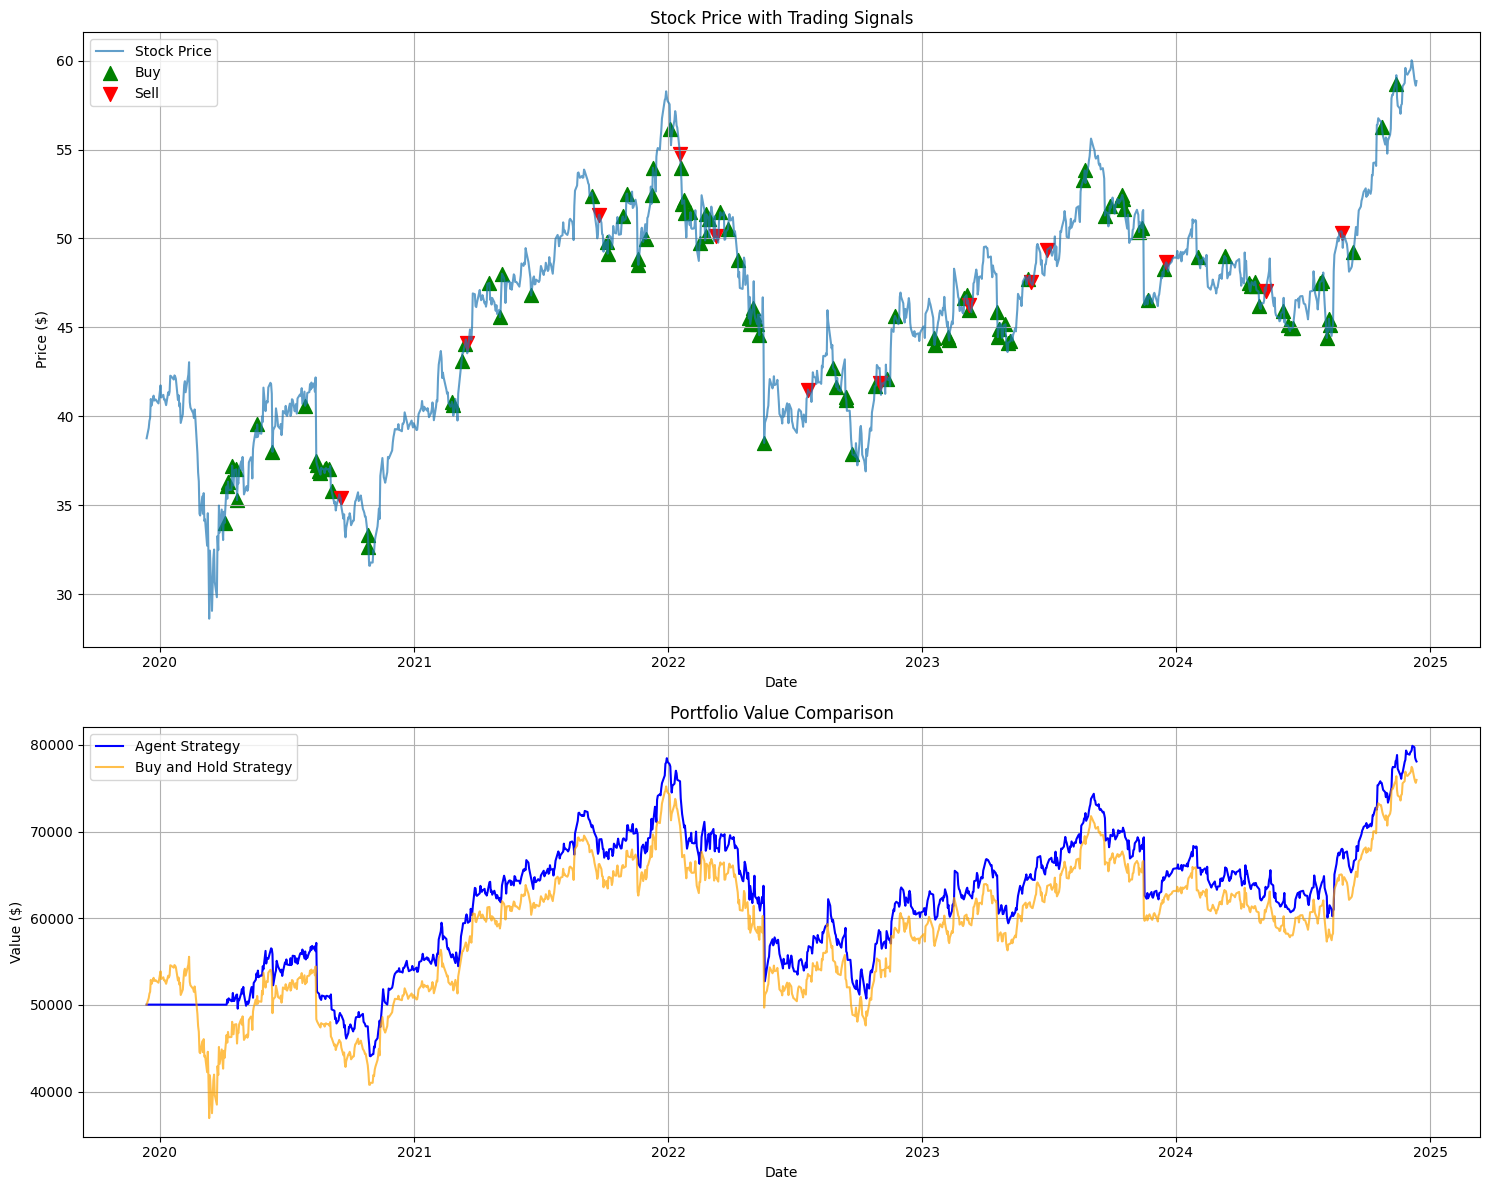


=== Performance Comparison ===
Initial Investment: $50,033.49

Agent Strategy:
Final Value: $78,090.22
Total Return: 56.08%
Number of Trades: 125

Buy and Hold Strategy:
Final Value: $75,959.33
Total Return: 51.82%

Risk Metrics:
Agent Sharpe Ratio: 0.53
Buy-Hold Sharpe Ratio: 0.44
Agent Maximum Drawdown: 35.34%
Buy-Hold Maximum Drawdown: 36.68%


In [427]:
def visualize_trades_with_benchmark(env, agent, df):
    # Run agent strategy
    state = env.reset()
    done = False
    
    buy_dates = []
    sell_dates = []
    portfolio_values = [env.balance]
    initial_balance = env.balance
    dates = df.index
    current_step = 0
    
    while not done:
        action = agent.act(state)
        next_state, reward, done, info = env.step(action)
        
        if action[0] == 2:  # Buy
            buy_dates.append(dates[current_step])
        elif action[0] == 0:  # Sell
            sell_dates.append(dates[current_step])
            
        portfolio_values.append(info['portfolio_value'])
        state = next_state
        current_step += 1
    
    # Calculate buy-and-hold strategy
    initial_stock_price = df['Close'].iloc[0]
    num_shares_buyhold = initial_balance / initial_stock_price
    buyhold_values = df['Close'] * num_shares_buyhold
    
    # Create subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), height_ratios=[1.5, 1])
    
    # Plot 1: Stock price with buy/sell points
    ax1.plot(dates, df['Close'], label='Stock Price', alpha=0.7)
    ax1.scatter(buy_dates, df.loc[buy_dates]['Close'], 
                color='green', marker='^', label='Buy', s=100)
    ax1.scatter(sell_dates, df.loc[sell_dates]['Close'], 
                color='red', marker='v', label='Sell', s=100)
    ax1.set_title('Stock Price with Trading Signals')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Price ($)')
    ax1.legend()
    ax1.grid(True)
    
    # Plot 2: Portfolio Value Comparison
    ax2.plot(dates[:len(portfolio_values)], portfolio_values, 
             label='Agent Strategy', color='blue')
    ax2.plot(dates, buyhold_values, 
             label='Buy and Hold Strategy', color='orange', alpha=0.7)
    ax2.set_title('Portfolio Value Comparison')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Value ($)')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate and print statistics
    agent_final_value = portfolio_values[-1]
    buyhold_final_value = buyhold_values.iloc[-1]
    
    agent_return = ((agent_final_value - initial_balance) / initial_balance) * 100
    buyhold_return = ((buyhold_final_value - initial_balance) / initial_balance) * 100
    
    print("\n=== Performance Comparison ===")
    print(f"Initial Investment: ${initial_balance:,.2f}")
    print("\nAgent Strategy:")
    print(f"Final Value: ${agent_final_value:,.2f}")
    print(f"Total Return: {agent_return:.2f}%")
    print(f"Number of Trades: {len(buy_dates) + len(sell_dates)}")
    
    print("\nBuy and Hold Strategy:")
    print(f"Final Value: ${buyhold_final_value:,.2f}")
    print(f"Total Return: {buyhold_return:.2f}%")
    
    # Calculate additional metrics
    agent_values = np.array(portfolio_values)
    agent_returns = np.diff(agent_values) / agent_values[:-1]
    buyhold_returns = buyhold_values.pct_change().dropna()
    
    agent_sharpe = np.sqrt(252) * np.mean(agent_returns) / np.std(agent_returns)
    buyhold_sharpe = np.sqrt(252) * np.mean(buyhold_returns) / np.std(buyhold_returns)
    
    # Maximum drawdown calculation
    agent_peak = np.maximum.accumulate(agent_values)
    agent_drawdown = (agent_peak - agent_values) / agent_peak
    agent_max_drawdown = np.max(agent_drawdown) * 100
    
    buyhold_peak = np.maximum.accumulate(buyhold_values)
    buyhold_drawdown = (buyhold_peak - buyhold_values) / buyhold_peak
    buyhold_max_drawdown = np.max(buyhold_drawdown) * 100
    
    print("\nRisk Metrics:")
    print(f"Agent Sharpe Ratio: {agent_sharpe:.2f}")
    print(f"Buy-Hold Sharpe Ratio: {buyhold_sharpe:.2f}")
    print(f"Agent Maximum Drawdown: {agent_max_drawdown:.2f}%")
    print(f"Buy-Hold Maximum Drawdown: {buyhold_max_drawdown:.2f}%")

# Run the visualization with benchmark comparison
visualize_trades_with_benchmark(env, agent, df)


Mean evaluation reward: -3.67


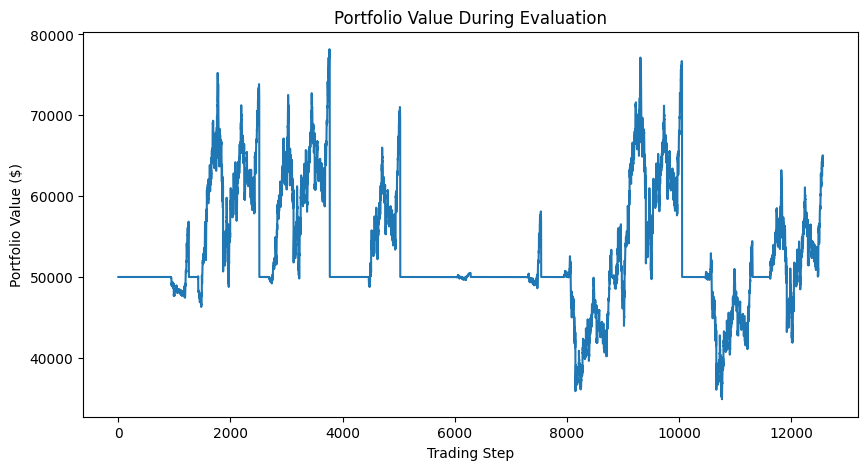

In [428]:
def evaluate_agent(env, agent, episodes=10):
    total_rewards = []
    portfolio_values = []
    
    for episode in range(episodes):
        state = env.reset()
        done = False
        episode_reward = 0
        
        while not done:
            action = agent.act(state)  # During evaluation, we don't need epsilon-greedy
            next_state, reward, done, info = env.step(action)
            
            state = next_state
            episode_reward += reward
            portfolio_values.append(info['portfolio_value'])
        
        total_rewards.append(episode_reward)
        
    return np.mean(total_rewards), portfolio_values

# Evaluate the trained agent
mean_reward, portfolio_history = evaluate_agent(env, agent)
print(f"Mean evaluation reward: {mean_reward:.2f}")

# Plot portfolio value over time
plt.figure(figsize=(10, 5))
plt.plot(portfolio_history)
plt.title('Portfolio Value During Evaluation')
plt.xlabel('Trading Step')
plt.ylabel('Portfolio Value ($)')
plt.show()

In [431]:
# After your imports, add:
from itertools import product
import json
from datetime import datetime

def grid_search(env, param_grid, episodes_per_combination=10, evaluation_episodes=5):
    """
    Perform grid search over hyperparameters
    
    Args:
        env: The trading environment
        param_grid: Dictionary of parameters and their possible values
        episodes_per_combination: Number of training episodes per parameter combination
        evaluation_episodes: Number of evaluation episodes per trained agent
    """
    # Generate all combinations of parameters
    param_keys = list(param_grid.keys())
    param_values = list(param_grid.values())
    param_combinations = list(product(*param_values))
    
    results = []
    best_reward = float('-inf')
    best_params = None
    best_agent = None
    
    # Create a timestamp for saving results
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    for combination in param_combinations:
        params = dict(zip(param_keys, combination))
        print(f"\nTesting parameters: {params}")
        
        # Create agent with current parameters
        agent = DQNAgent(
            state_size=env.observation_space.shape[0],
            action_size=env.action_space.nvec.prod(),
            learning_rate=params['learning_rate'],
            gamma=params['gamma'],
            epsilon=params['epsilon'],
            epsilon_min=params['epsilon_min'],
            epsilon_decay=params['epsilon_decay'],
            memory_size=params['memory_size'],
            batch_size=params['batch_size']
        )
        
        # Train agent
        training_rewards = []
        for episode in range(episodes_per_combination):
            state = env.reset()
            done = False
            episode_reward = 0
            
            while not done:
                action = agent.act(state)
                next_state, reward, done, info = env.step(action)
                agent.remember(state, action, reward, next_state, done)
                agent.train()
                
                state = next_state
                episode_reward += reward
            
            training_rewards.append(episode_reward)
            if (episode + 1) % 5 == 0:
                print(f"Episode {episode + 1}/{episodes_per_combination}, "
                      f"Average Reward: {np.mean(training_rewards[-5:]):.2f}")
        
        # Evaluate agent
        mean_reward, portfolio_values = evaluate_agent(env, agent, episodes=evaluation_episodes)
        
        result = {
            'parameters': params,
            'mean_evaluation_reward': mean_reward,
            'final_portfolio_value': portfolio_values[-1],
            'training_rewards': training_rewards
        }
        results.append(result)
        
        # Update best parameters if current combination is better
        if mean_reward > best_reward:
            best_reward = mean_reward
            best_params = params
            best_agent = copy.deepcopy(agent)
        
        # Save results to file
        with open(f'grid_search_results_{timestamp}.json', 'w') as f:
            json.dump(results, f, indent=4)
    
    return best_params, best_agent, results

# Define parameter grid
param_grid = {
    'learning_rate': [0.001, 0.0001],
    'gamma': [0.95, 0.99],
    'epsilon': [1.0],
    'epsilon_min': [0.01, 0.1],
    'epsilon_decay': [0.995, 0.999],
    'memory_size': [10000],
    'batch_size': [32, 64]
}

# Run grid search
best_params, best_agent, all_results = grid_search(env, param_grid)

print("\n=== Grid Search Results ===")
print(f"Best parameters: {best_params}")
print(f"Best mean reward: {max(result['mean_evaluation_reward'] for result in all_results):.2f}")

# Visualize results with the best agent
visualize_trades_with_benchmark(env, best_agent, df)

# Plot training rewards for all parameter combinations
plt.figure(figsize=(15, 8))
for result in all_results:
    params_str = str(result['parameters'])
    plt.plot(result['training_rewards'], label=params_str[:50] + '...')
plt.title('Training Rewards Across Different Parameters')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Testing parameters: {'learning_rate': 0.001, 'gamma': 0.95, 'epsilon': 1.0, 'epsilon_min': 0.01, 'epsilon_decay': 0.995, 'memory_size': 10000, 'batch_size': 32}


TypeError: DQNAgent.__init__() got an unexpected keyword argument 'learning_rate'